In [2]:
import pandas as pd
import numpy as np
import pymc3 as pm

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
C:\ProgramData\Anaconda3\lib\site-packages\theano\configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.


Couldn't import dot_parser, loading of dot files will not be possible.


WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import time

plt.style.use('fivethirtyeight')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

### Reading in the data csv

In [8]:
df = pd.read_csv('globalterrorismdb_0617dist.csv', encoding='ISO-8859-1', low_memory=False)
print(df.shape)
df[:5]

(170350, 135)


,eventid,iyear,imonth,iday,approxdate,extended,resolution,country,country_txt,region,...,addnotes,scite1,scite2,scite3,dbsource,INT_LOG,INT_IDEO,INT_MISC,INT_ANY,related
0,197000000001,1970,7,2,NaN,0,NaN,58,Dominican Republic,2,...,NaN,NaN,NaN,NaN,PGIS,0,0,0,0,NaN
1,197000000002,1970,0,0,NaN,0,NaN,130,Mexico,1,...,NaN,NaN,NaN,NaN,PGIS,0,1,1,1,NaN
2,197001000001,1970,1,0,NaN,0,NaN,160,Philippines,5,...,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN
3,197001000002,1970,1,0,NaN,0,NaN,78,Greece,8,...,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN
4,197001000003,1970,1,0,NaN,0,NaN,101,Japan,4,...,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN


### Initial EDA

In [9]:
df.isnull().sum().sort_values(ascending=False)

gsubname3           170337
weapsubtype4_txt    170279
weapsubtype4        170279
weaptype4           170276
weaptype4_txt       170276
claimmode3          170230
claimmode3_txt      170230
gsubname2           170201
claim3              170087
guncertain3         170085
gname3              170081
divert              170037
attacktype3         169976
attacktype3_txt     169976
ransomnote          169879
ransompaidus        169863
ransomamtus         169854
claimmode2          169818
claimmode2_txt      169818
ransompaid          169643
corp3               169466
targsubtype3        169389
targsubtype3_txt    169389
natlty3             169344
natlty3_txt         169344
target3             169317
targtype3           169316
targtype3_txt       169316
ransomamt           169071
weapsubtype3_txt    168843
                     ...  
region                   0
region_txt               0
imonth                   0
iday                     0
country                  0
INT_IDEO                 0
I

In [10]:
# number of attack type 2/3 null observations
df[['attacktype2', 'attacktype2_txt', 'attacktype3', 'attacktype3_txt']].isnull().sum()

attacktype2        164720
attacktype2_txt    164720
attacktype3        169976
attacktype3_txt    169976
dtype: int64

#### Attack Types and Corresponding Number within Dataset
- 1 = Assasination
- 2 = Armed Assault
- 3 = Bombing/Explosion
- 4 = Hijacking
- 5 = Hostage Taking (BARRICADE INCIDENT)
- 6 = Hostage Taking (Kidnapping)
- 7 = Facility/Infastructure attack
- 8 = Unarmed assault
- 9 = Unknown

In [11]:
# number of each type of primary attack 
print(df.attacktype1_txt.value_counts())

Bombing/Explosion                      83073
Armed Assault                          40223
Assassination                          18402
Hostage Taking (Kidnapping)            10233
Facility/Infrastructure Attack          9581
Unknown                                 6425
Unarmed Assault                          913
Hostage Taking (Barricade Incident)      902
Hijacking                                598
Name: attacktype1_txt, dtype: int64


In [14]:
# forming dataframe of bombings only as primary attack
df_bombings = df[df.attacktype1 == 3]
df_bombings.shape

(83073, 135)

In [10]:
# already saved, commented out as to not run again
# df_bombings.to_csv('bombings.csv')

In [15]:
# sorting out by most bombings per year
df_bombings.iyear.value_counts().sort_values(ascending=False)

2014    8775
2015    7608
2016    7075
2013    6672
2012    5079
2008    2660
2011    2589
2009    2566
2010    2509
1991    1988
2007    1864
1989    1797
1984    1776
1992    1738
1990    1731
1988    1649
1986    1506
2006    1500
1985    1482
1987    1477
1983    1246
1996    1217
1994    1153
1982    1125
1997    1123
1981    1082
2005    1063
1979    1057
1980     997
2000     904
2001     801
1995     791
2002     721
2003     680
2004     656
1999     652
1978     644
1977     635
1998     504
1976     419
1975     370
1970     333
1974     284
1971     238
1972     188
1973     149
Name: iyear, dtype: int64

In [18]:
# df['Event_Date'] = str(df.iyear)+"-"+str(df.imonth)+"-"+str(df.iday)
# df.head()

In [19]:
# Group name counts of main perpetrators for all attacks
df.gname.value_counts().sort_values(ascending=False)

Unknown                                                             78306
Taliban                                                              6575
Shining Path (SL)                                                    4551
Islamic State of Iraq and the Levant (ISIL)                          4287
Farabundo Marti National Liberation Front (FMLN)                     3351
Al-Shabaab                                                           2683
Irish Republican Army (IRA)                                          2669
Revolutionary Armed Forces of Colombia (FARC)                        2481
New People's Army (NPA)                                              2414
Kurdistan Workers' Party (PKK)                                       2152
Boko Haram                                                           2077
Basque Fatherland and Freedom (ETA)                                  2024
Communist Party of India - Maoist (CPI-Maoist)                       1766
Liberation Tigers of Tamil Eelam (LTTE

In [20]:
# looking at all ISIS or ISIL attacks
df[df['gname'].str.contains('ISIL' or 'ISIS')] #or df['gname'].str.contains('ISIL')]

,eventid,iyear,imonth,iday,approxdate,extended,resolution,country,country_txt,region,...,addnotes,scite1,scite2,scite3,dbsource,INT_LOG,INT_IDEO,INT_MISC,INT_ANY,related
116020,201304180002,2013,4,18,NaN,0,NaN,95,Iraq,10,...,Casualty numbers for this incident conflict ac...,"""Suicide attack kills 26 in Iraq,"" New Straits...","""Suicide bomber kills at least 27 in Baghdad c...","""Bombing kills 32 at Baghdad cafe ahead of vot...",START Primary Collection,0,1,0,1,NaN
116092,201304200018,2013,4,20,NaN,0,NaN,95,Iraq,10,...,NaN,"""Iraqis vote in local elections despite violen...","""Poll centre attacks mar Iraq provincial vote,...","""Bombings mar start to milestone Iraq election...",START Primary Collection,0,1,0,1,"201304200018, 201304200019, 201304200020"
116093,201304200019,2013,4,20,NaN,0,NaN,95,Iraq,10,...,NaN,"""Iraqis vote in local elections despite violen...","""UPDATE 1-Bombs mar start to first Iraq vote s...","""Scattered violence in Iraq's first elections ...",START Primary Collection,0,1,0,1,"201304200019, 201304200018, 201304200020"
116094,201304200020,2013,4,20,NaN,0,NaN,95,Iraq,10,...,NaN,"""Iraqis vote in local elections despite violen...","""UPDATE 1-Bombs mar start to first Iraq vote s...","""Scattered violence in Iraq's first elections ...",START Primary Collection,0,1,0,1,"201304200020, 201304200018, 201304200019"
116837,201305110007,2013,5,11,NaN,0,NaN,209,Turkey,10,...,Casualty numbers for this incident conflict ac...,"""Turkey 'arrests terror suspects',"" BBC, May 3...","""Death toll in Turkey car bombings rises to 51...","""Turkey twin bombings death toll rises to 48,""...",START Primary Collection,1,1,1,1,"201305110007, 201305110008"
116838,201305110008,2013,5,11,NaN,0,NaN,209,Turkey,10,...,Casualty numbers for this incident conflict ac...,"""Turkey 'arrests terror suspects',"" BBC, May 3...","""Death toll in Turkey car bombings rises to 51...","""Turkey opens trial over deadly ReyhanlÄ± bomb...",START Primary Collection,1,1,1,1,"201305110008, 201305110007"
117027,201305160006,2013,5,16,NaN,0,NaN,95,Iraq,10,...,Casualty numbers for this attack conflict acro...,"""3 people killed in car bombing in Baghdad Shi...","""Car bombs, shooting in Iraq leave 15 people d...",NaN,START Primary Collection,0,1,0,1,"201305160006, 201305160007, 201305160008"
117028,201305160007,2013,5,16,NaN,0,NaN,95,Iraq,10,...,NaN,"""Car bombs, shooting in Iraq leave 15 people d...",NaN,NaN,START Primary Collection,0,1,0,1,"201305160007, 201305160006, 201305160008"
117029,201305160008,2013,5,16,NaN,0,NaN,95,Iraq,10,...,NaN,"""Car bombs, shooting in Iraq leave 15 people d...",NaN,NaN,START Primary Collection,0,1,0,1,"201305160008, 201305160006, 201305160007"
117030,201305160009,2013,5,16,NaN,0,NaN,95,Iraq,10,...,Casualty numbers for this attack conflict acro...,"""Wave of bombings, shootings kills 11 in Iraq,...","""Car bombs, shooting in Iraq leave 15 people d...",NaN,START Primary Collection,0,1,0,1,NaN


In [21]:
df_bombings.iyear.value_counts()

2014    8775
2015    7608
2016    7075
2013    6672
2012    5079
2008    2660
2011    2589
2009    2566
2010    2509
1991    1988
2007    1864
1989    1797
1984    1776
1992    1738
1990    1731
1988    1649
1986    1506
2006    1500
1985    1482
1987    1477
1983    1246
1996    1217
1994    1153
1982    1125
1997    1123
1981    1082
2005    1063
1979    1057
1980     997
2000     904
2001     801
1995     791
2002     721
2003     680
2004     656
1999     652
1978     644
1977     635
1998     504
1976     419
1975     370
1970     333
1974     284
1971     238
1972     188
1973     149
Name: iyear, dtype: int64

In [22]:
df.region.value_counts()

10    46511
6     41497
3     18762
8     16307
11    15491
5     11453
2     10340
9      5031
1      3346
4       794
7       554
12      264
Name: region, dtype: int64

In [24]:
# forming dataframe of middle east attacks only
df_middle_east = df[df.region == 10]
print(df_middle_east.shape)
df_middle_east[:5]

(46511, 135)


,eventid,iyear,imonth,iday,approxdate,extended,resolution,country,country_txt,region,...,addnotes,scite1,scite2,scite3,dbsource,INT_LOG,INT_IDEO,INT_MISC,INT_ANY,related
95,197002280001,1970,2,28,NaN,0,NaN,102,Jordan,10,...,NaN,NaN,NaN,NaN,PGIS,-9,-9,0,-9,NaN
133,197003140002,1970,3,14,NaN,0,NaN,60,Egypt,10,...,NaN,NaN,NaN,NaN,PGIS,-9,-9,0,-9,NaN
158,197003290002,1970,3,29,NaN,0,NaN,110,Lebanon,10,...,NaN,NaN,NaN,NaN,PGIS,0,1,1,1,NaN
195,197004150001,1970,4,15,NaN,0,NaN,102,Jordan,10,...,NaN,NaN,NaN,NaN,PGIS,0,1,1,1,NaN
226,197004250001,1970,4,25,NaN,0,NaN,209,Turkey,10,...,NaN,NaN,NaN,NaN,PGIS,1,0,1,1,NaN


In [25]:
df_middle_east.gname.value_counts()

Unknown                                                          27550
Islamic State of Iraq and the Levant (ISIL)                       4260
Kurdistan Workers' Party (PKK)                                    1980
Palestinians                                                      1104
Al-Qaida in the Arabian Peninsula (AQAP)                           972
Houthi extremists (Ansar Allah)                                    893
Al-Qaida in Iraq                                                   635
Hamas (Islamic Resistance Movement)                                404
Palestinian Extremists                                             389
Hezbollah                                                          377
Algerian Islamic Extremists                                        373
Muslim extremists                                                  351
Tripoli Province of the Islamic State                              327
Sinai Province of the Islamic State                                323
Al-Nus

In [26]:
# middle east bombings only
df_mideast_bombings = df_middle_east[df_middle_east.attacktype1 == 3]
df_mideast_bombings.shape

(28314, 135)

In [27]:
df_mideast_bombings.head()

,eventid,iyear,imonth,iday,approxdate,extended,resolution,country,country_txt,region,...,addnotes,scite1,scite2,scite3,dbsource,INT_LOG,INT_IDEO,INT_MISC,INT_ANY,related
133,197003140002,1970,3,14,NaN,0,NaN,60,Egypt,10,...,NaN,NaN,NaN,NaN,PGIS,-9,-9,0,-9,NaN
158,197003290002,1970,3,29,NaN,0,NaN,110,Lebanon,10,...,NaN,NaN,NaN,NaN,PGIS,0,1,1,1,NaN
195,197004150001,1970,4,15,NaN,0,NaN,102,Jordan,10,...,NaN,NaN,NaN,NaN,PGIS,0,1,1,1,NaN
226,197004250001,1970,4,25,NaN,0,NaN,209,Turkey,10,...,NaN,NaN,NaN,NaN,PGIS,1,0,1,1,NaN
334,197006090002,1970,6,9,NaN,0,NaN,94,Iran,10,...,NaN,NaN,NaN,NaN,PGIS,0,0,1,1,NaN


### Part One: Bayesian Inference

In [30]:
# fingind average annual bombings in mid east prior to 2003
pre_03_mean = df_mideast_bombings[df_mideast_bombings.iyear <= 2003].iyear.value_counts().values.mean()
print("Mean annual bombings in middle east prior to 2003:", round(pre_03_mean, 3))

# fingind average annual bombings in mid east after to 2003
post_03_mean = df_mideast_bombings[df_mideast_bombings.iyear > 2003].iyear.value_counts().values.mean()
print("Mean annual bombings in middle east post 2003:", round(post_03_mean, 3))

Mean annual bombings in middle east prior to 2003: 138.788
Mean annual bombings in middle east post 2003: 1825.692


In [32]:
pre2003_mideast_bombings = df_mideast_bombings[df_mideast_bombings.iyear <= 2003].iyear.value_counts().values
post2003_mideast_bombings = df_mideast_bombings[df_mideast_bombings.iyear > 2003].iyear.value_counts().values

In [35]:
# Establishing a prior based on the mean & std dev of number of bombings per year, regardless of region or time period
prior_mean = df_bombings.iyear.value_counts().values.mean()
prior_std = df_bombings.iyear.value_counts().values.std()

print('Prior mean:', prior_mean)
print('Prior std dev:', prior_std)

Prior mean: 1805.9347826086957
Prior std dev: 1979.456813965737


(array([18., 18.,  5.,  0.,  0.,  1.,  0.,  1.,  2.,  1.]),
 array([ 149. , 1011.6, 1874.2, 2736.8, 3599.4, 4462. , 5324.6, 6187.2,
        7049.8, 7912.4, 8775. ]),
 <a list of 10 Patch objects>)

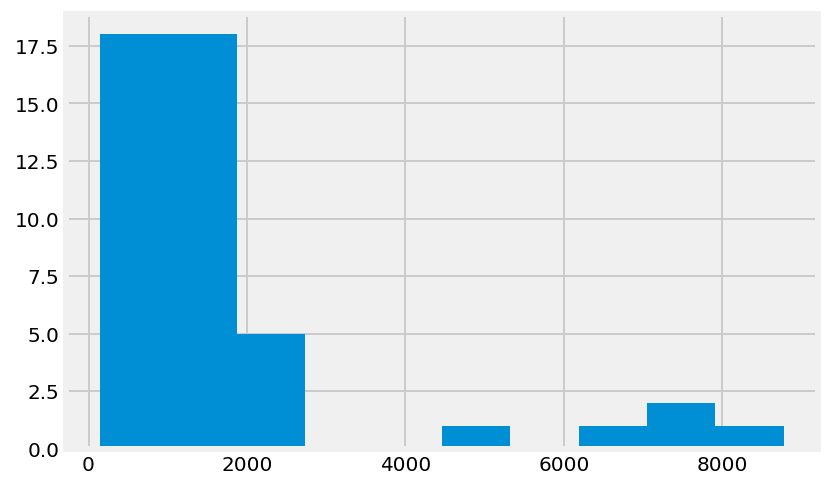

In [36]:
plt.hist(df_bombings.iyear.value_counts().values)

In [38]:
# Setting up a normal distribution for the mean of annual bombings over the course of the entire time period. 
# This assures the priors are both the same, and we will be able to conclude later if the data had an affect 
with pm.Model() as model:
    
    before2003_mean = pm.Normal('Before2003_Mean', prior_mean, sd=prior_std)
    post2003_mean = pm.Normal('Post2003_Mean', prior_mean, sd=prior_std)

In [39]:
# Setting up a normal distribution for the std. deviation of bombings/year
prior_std_lower = 50.0
prior_std_upper = 2500.00

with model:
    
    before2003_std = pm.Uniform('Before2003_std', lower=prior_std_lower, upper=prior_std_upper)
    post2003_std = pm.Uniform('Post2003_std', lower=prior_std_lower, upper=prior_std_upper)


In [40]:
# Constructing the posterior distributions for each group after given the data
with model:
    
    before2003 = pm.Normal('Before2003', mu=before2003_mean, sd=before2003_std, observed=pre2003_mideast_bombings)
    post2003 = pm.Normal('Post2003', mu=post2003_mean, sd=post2003_std, observed=post2003_mideast_bombings)

In [41]:
# Setting up a distribution for the difference of means/diff of stds between the two populations
# Also setting up a distribution for the effect size. An effect size of 0 indicates no difference btw the two
# These distributions wil help us learn more about given parameters
with model:
    
    diff_of_means = pm.Deterministic('difference of means', post2003_mean - before2003_mean)
    diff_of_stds = pm.Deterministic('difference of stds', post2003_std - before2003_std)
    effect_size = pm.Deterministic('effect size', 
                                   diff_of_means / np.sqrt((before2003_std**2 + post2003_std**2) / 2))
    


### Fitting the Model with MCMC

In [43]:
# Starting the process of MCMC estimation of posteriors(constructing arbitrary posterior distributions given our data and priors)
t0 = time.time()
with model:
    trace = pm.sample(2500) # Trace is a collection of all data points gathered by the MCMC chain
t1 = time.time()

print(t1 - t0)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [Post2003_std, Before2003_std, Post2003_Mean, Before2003_Mean]
Sampling 2 chains: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 6000/6000 [07:14<00:00, 13.82draws/s]
C:\ProgramData\Anaconda3\lib\site-packages\mkl_fft\_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)
The acceptance probability does not match the target. It is 0.9044209717924456, but should be close to 0.8. Try to increase the number of tuning steps.


463.7395918369293


In [45]:
# Plotting the posteriors and their distributions
pm.traceplot(trace)

ImportError: ArviZ is not installed. In order to use `plot_trace`:
pip install arviz

In [48]:
t0 = time.time()
with model:
    trace = pm.sample(25000)
t1 = time.time()

print(t1 - t0)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [Post2003_std, Before2003_std, Post2003_Mean, Before2003_Mean]
Sampling 2 chains: 100%|████████████████████████████████████████████████████████████████████████████████████████| 51000/51000 [36:57<00:00, 17.01draws/s]
C:\ProgramData\Anaconda3\lib\site-packages\mkl_fft\_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)
There were 209 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5588303921371065, but should be close to 0.8. Try to increase the number of tuning steps.
There were 7 divergences after tuni

2249.308376789093


In [49]:
pm.traceplot(trace)

ImportError: ArviZ is not installed. In order to use `plot_trace`:
pip install arviz

array([<matplotlib.axes._subplots.AxesSubplot object at 0x13cc36210>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x12179d5d0>], dtype=object)

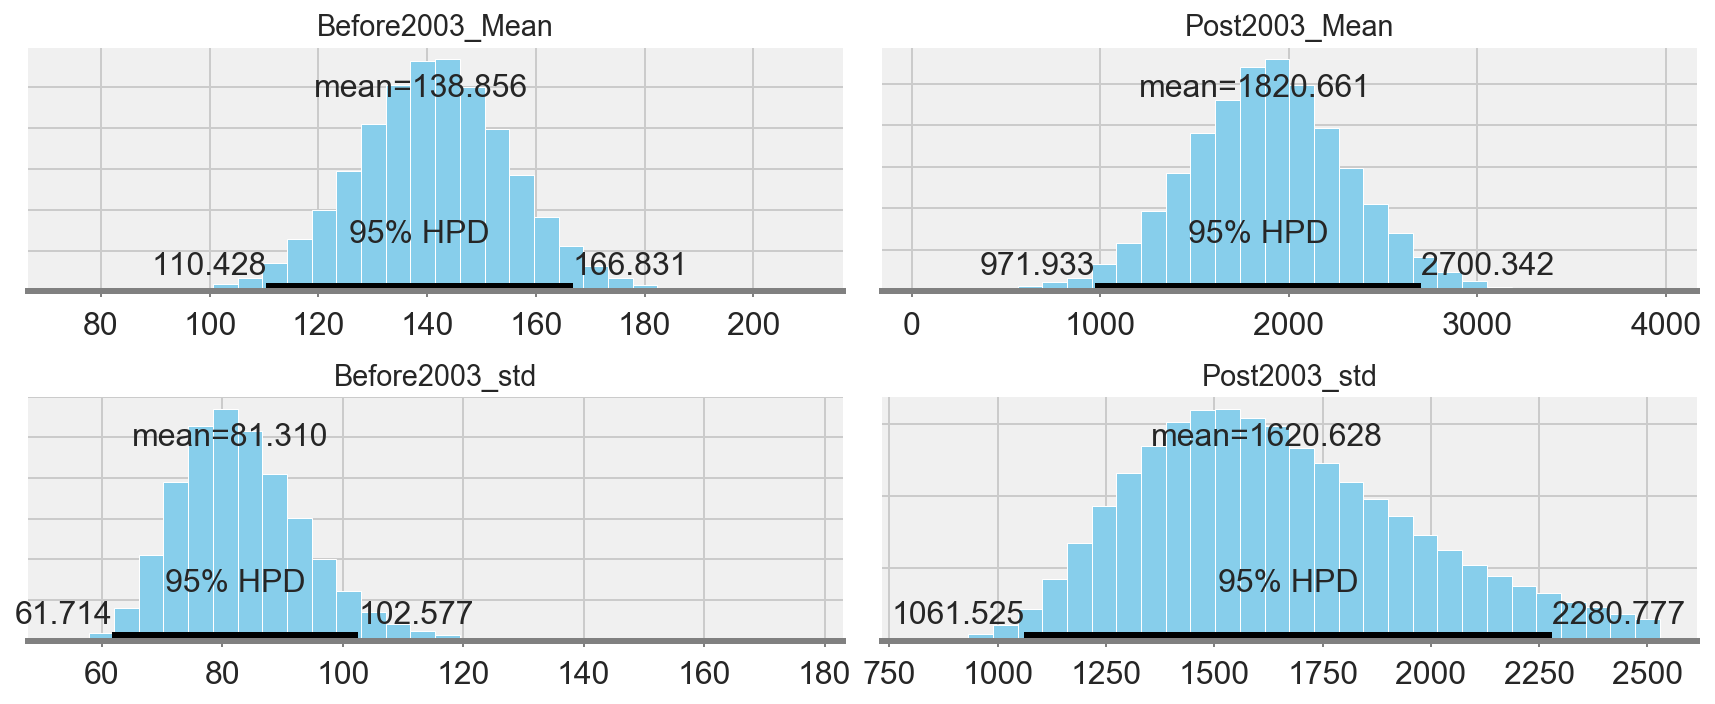

In [80]:
pm.plot_posterior(trace[3000:],
                  varnames=['Before2003_Mean', 'Post2003_Mean', 'Before2003_std', 'Post2003_std'],
                  color='#87ceeb')

array([<matplotlib.axes._subplots.AxesSubplot object at 0x13ba81350>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x13d460310>], dtype=object)

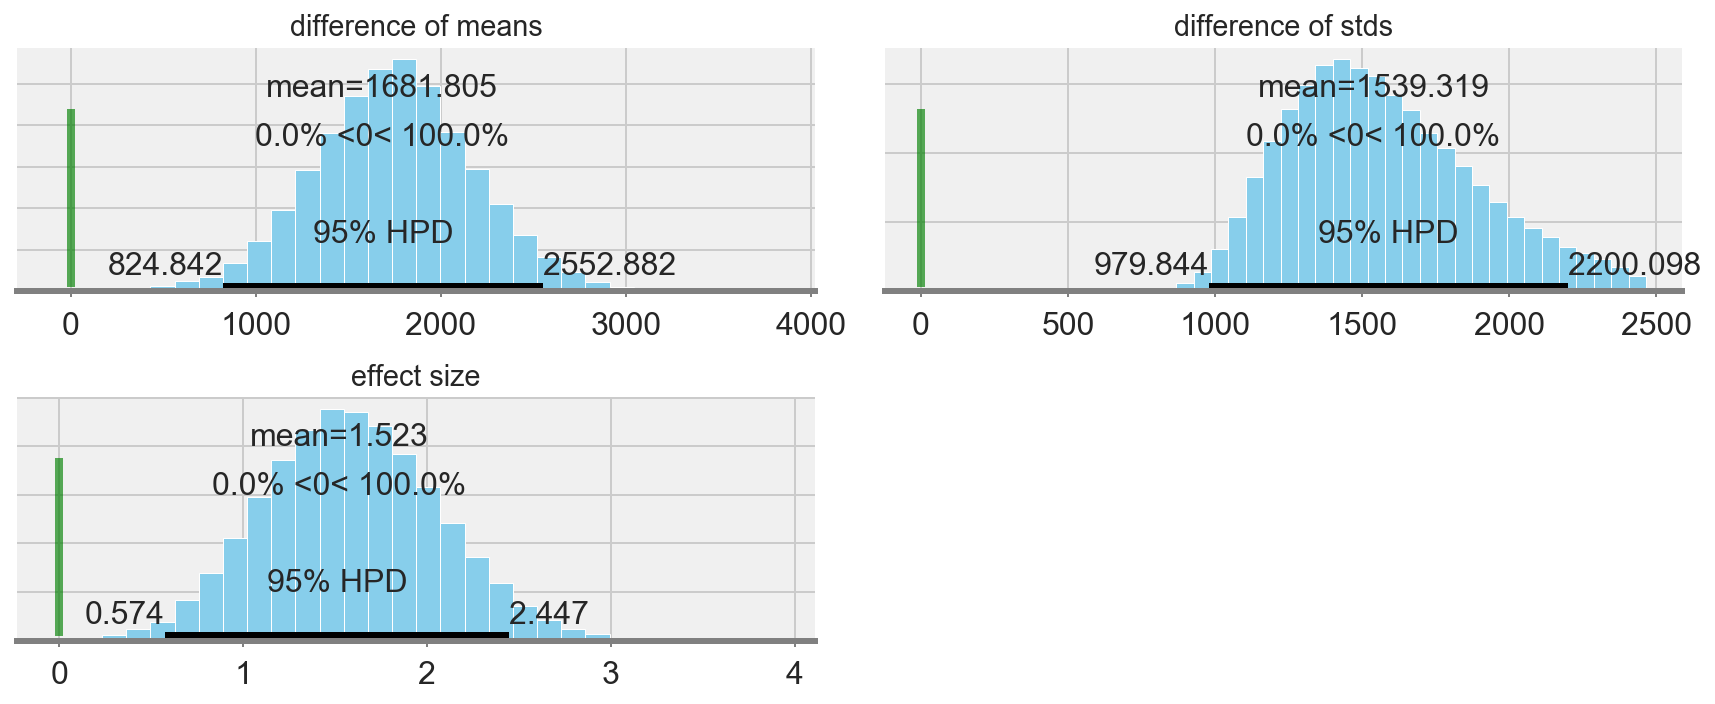

In [81]:
pm.plot_posterior(trace[3000:],
                  varnames=['difference of means', 'difference of stds', 'effect size'],
                  ref_val=0,
                  color='#87ceeb')

In [82]:
pm.summary(trace[3000:],
           varnames=['difference of means', 'difference of stds', 'effect size'])


difference of means:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  1681.805         438.575          5.637            [824.842, 2552.882]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  818.955        1395.864       1684.702       1963.381       2548.776


difference of stds:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  1539.319         319.570          1.849            [979.844, 2200.098]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  1019.048       1301.144       1500.606       1746.018       2251.817


effect size:

  Mean             SD               MC Error    

### From the above plots, there is a clear difference in posterior distributions of mean annual bombings in the middle east before and after 2003. I can say with a 95% credible interval that the mean bombings in the Middle East prior to 2003 lands between 110 and 166. While within the same 95% credible interval it can be stated that the annual mean bombings after 2003 is between 971 and 2700. 

## Part Three: Predicting 1993 Bombings 

In [11]:
df_mideast_bombings.head()

,eventid,iyear,imonth,iday,approxdate,extended,resolution,country,country_txt,region,...,addnotes,scite1,scite2,scite3,dbsource,INT_LOG,INT_IDEO,INT_MISC,INT_ANY,related
133,197003140002,1970,3,14,NaN,0,NaN,60,Egypt,10,...,NaN,NaN,NaN,NaN,PGIS,-9,-9,0,-9,NaN
158,197003290002,1970,3,29,NaN,0,NaN,110,Lebanon,10,...,NaN,NaN,NaN,NaN,PGIS,0,1,1,1,NaN
195,197004150001,1970,4,15,NaN,0,NaN,102,Jordan,10,...,NaN,NaN,NaN,NaN,PGIS,0,1,1,1,NaN
226,197004250001,1970,4,25,NaN,0,NaN,209,Turkey,10,...,NaN,NaN,NaN,NaN,PGIS,1,0,1,1,NaN
334,197006090002,1970,6,9,NaN,0,NaN,94,Iran,10,...,NaN,NaN,NaN,NaN,PGIS,0,0,1,1,NaN


In [63]:
# writing a function to have one column display the entire date of the attack
def combine64(years, months=1, days=None, weeks=None, hours=None, minutes=None,
              seconds=None, milliseconds=None, microseconds=None, nanoseconds=None):
    years = np.asarray(years) - 1970
    months = np.asarray(months) - 1
    types = ('<M8[Y]', '<m8[M]', '<m8[D]', '<m8[W]', '<m8[h]',
             '<m8[m]', '<m8[s]', '<m8[ms]', '<m8[us]', '<m8[ns]')
    vals = (years, months, days, weeks, hours, minutes, seconds,
            milliseconds, microseconds, nanoseconds)
    return sum(np.asarray(v, dtype=t) for t, v in zip(types, vals)
               if v is not None)

In [64]:
# using the above function to 
df_mideast_bombings['Date/Time_of_attack'] = combine64(df_mideast_bombings['iyear'], df_mideast_bombings['imonth']) 
                                                       

# features['datetime']=combine64(features['iyear'], features['imonth'], features['iday'])

/Users/elutins/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [65]:
df_mideast_bombings.head()

,eventid,iyear,imonth,iday,approxdate,extended,resolution,country,country_txt,region,...,scite1,scite2,scite3,dbsource,INT_LOG,INT_IDEO,INT_MISC,INT_ANY,related,Date/Time_of_attack
133,197003140002,1970,3,14,NaN,0,NaN,60,Egypt,10,...,NaN,NaN,NaN,PGIS,-9,-9,0,-9,NaN,1970-03-01
158,197003290002,1970,3,29,NaN,0,NaN,110,Lebanon,10,...,NaN,NaN,NaN,PGIS,0,1,1,1,NaN,1970-03-01
195,197004150001,1970,4,15,NaN,0,NaN,102,Jordan,10,...,NaN,NaN,NaN,PGIS,0,1,1,1,NaN,1970-04-01
226,197004250001,1970,4,25,NaN,0,NaN,209,Turkey,10,...,NaN,NaN,NaN,PGIS,1,0,1,1,NaN,1970-04-01
334,197006090002,1970,6,9,NaN,0,NaN,94,Iran,10,...,NaN,NaN,NaN,PGIS,0,0,1,1,NaN,1970-06-01


In [66]:
df_bombings['Date/Time_of_attack'] = combine64(df_bombings['iyear'], df_bombings['imonth']) 
                                               

df_bombings.head()

/Users/elutins/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,eventid,iyear,imonth,iday,approxdate,extended,resolution,country,country_txt,region,...,scite1,scite2,scite3,dbsource,INT_LOG,INT_IDEO,INT_MISC,INT_ANY,related,Date/Time_of_attack
3,197001000002,1970,1,0,NaN,0,NaN,78,Greece,8,...,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN,1970-01-01
7,197001020002,1970,1,2,NaN,0,NaN,217,United States,1,...,Committee on Government Operations United Stat...,"Christopher Hewitt, ""Political Violence and Te...",NaN,Hewitt Project,-9,-9,0,-9,NaN,1970-01-01
10,197001050001,1970,1,1,NaN,0,NaN,217,United States,1,...,NaN,NaN,NaN,PGIS,0,0,0,0,NaN,1970-01-01
15,197001100001,1970,1,10,NaN,0,NaN,499,East Germany (GDR),9,...,NaN,NaN,NaN,PGIS,0,1,1,1,NaN,1970-01-01
17,197001120001,1970,1,12,NaN,0,NaN,217,United States,1,...,"""Blast Damages Flatbush School,"" New York Time...","Linda Greenhouse, ""Madison School Puzzled By B...",Committee on Government Operations United Stat...,Hewitt Project,-9,-9,0,-9,NaN,1970-01-01


In [8]:
regions = df_bombings.region_txt.unique()
regions

array(['Western Europe', 'North America', 'Eastern Europe',
       'Southeast Asia', 'Middle East & North Africa', 'South America',
       'Australasia & Oceania', 'East Asia', 'Central America & Caribbean',
       'South Asia', 'Sub-Saharan Africa', 'Central Asia'], dtype=object)

In [67]:
# forming a seperate dataframe strictly consisting of the region and how many bombings per region at every given date
region_dict = {}
for item in regions:
    region_dict[item]=(df_bombings[df_bombings['region_txt']==item].groupby('Date/Time_of_attack').attacktype1.count())

region_dict['Middle East & North Africa']
    

Date/Time_of_attack
1970-03-01      2
1970-04-01      2
1970-06-01      2
1970-08-01      1
1970-10-01      4
1970-11-01      2
1970-12-01      1
1971-01-01      5
1971-02-01     10
1971-03-01      3
1971-04-01      6
1971-05-01      3
1971-06-01      1
1971-07-01      1
1971-09-01      3
1971-10-01      1
1971-11-01      2
1971-12-01      1
1972-01-01      5
1972-05-01     10
1972-08-01      4
1972-11-01      3
1972-12-01      1
1973-01-01      4
1973-03-01      2
1973-04-01      4
1973-05-01      2
1973-09-01      1
1973-12-01      1
1974-02-01      3
             ... 
2014-07-01    490
2014-08-01    350
2014-09-01    279
2014-10-01    320
2014-11-01    297
2014-12-01    284
2015-01-01    325
2015-02-01    310
2015-03-01    319
2015-04-01    298
2015-05-01    321
2015-06-01    353
2015-07-01    357
2015-08-01    361
2015-09-01    271
2015-10-01    326
2015-11-01    317
2015-12-01    307
2016-01-01    336
2016-02-01    344
2016-03-01    316
2016-04-01    360
2016-05-01    486
2016-06-

In [68]:
df_bombings_by_region = pd.DataFrame(region_dict)
df_bombings_by_region.head()

,Australasia & Oceania,Central America & Caribbean,Central Asia,East Asia,Eastern Europe,Middle East & North Africa,North America,South America,South Asia,Southeast Asia,Sub-Saharan Africa,Western Europe
Date/Time_of_attack,,,,,,,,,,,,
1970-01-01,NaN,NaN,NaN,NaN,1.0,NaN,12.0,NaN,NaN,1.0,NaN,1.0
1970-02-01,NaN,NaN,NaN,NaN,NaN,NaN,30.0,NaN,NaN,NaN,NaN,2.0
1970-03-01,NaN,NaN,NaN,NaN,NaN,2.0,36.0,NaN,NaN,1.0,NaN,2.0
1970-04-01,NaN,NaN,NaN,NaN,NaN,2.0,43.0,NaN,NaN,1.0,NaN,NaN
1970-05-01,NaN,NaN,NaN,NaN,NaN,NaN,27.0,NaN,NaN,NaN,NaN,1.0


In [62]:
df_bombings_by_region.shape

(13650, 15)

In [47]:
df_bombings_by_region.index

DatetimeIndex(['1969-12-31', '1970-01-01', '1970-01-02', '1970-01-10',
               '1970-01-12', '1970-01-19', '1970-01-21', '1970-01-22',
               '1970-01-26', '1970-01-28',
               ...
               '2016-12-22', '2016-12-23', '2016-12-24', '2016-12-25',
               '2016-12-26', '2016-12-27', '2016-12-28', '2016-12-29',
               '2016-12-30', '2016-12-31'],
              dtype='datetime64[ns]', name=u'Date/Time_of_attack', length=13650, freq=None)

In [69]:
# dataframe of the count of bombings in every region indexed by month from 1970 - 2016.
df_bombings_by_region = df_bombings_by_region.fillna(0)

In [70]:

df_bombings_by_region.head()

,Australasia & Oceania,Central America & Caribbean,Central Asia,East Asia,Eastern Europe,Middle East & North Africa,North America,South America,South Asia,Southeast Asia,Sub-Saharan Africa,Western Europe
Date/Time_of_attack,,,,,,,,,,,,
1970-01-01,0.0,0.0,0.0,0.0,1.0,0.0,12.0,0.0,0.0,1.0,0.0,1.0
1970-02-01,0.0,0.0,0.0,0.0,0.0,0.0,30.0,0.0,0.0,0.0,0.0,2.0
1970-03-01,0.0,0.0,0.0,0.0,0.0,2.0,36.0,0.0,0.0,1.0,0.0,2.0
1970-04-01,0.0,0.0,0.0,0.0,0.0,2.0,43.0,0.0,0.0,1.0,0.0,0.0
1970-05-01,0.0,0.0,0.0,0.0,0.0,0.0,27.0,0.0,0.0,0.0,0.0,1.0


In [71]:
df_bombings_by_region.shape

(552, 12)

In [95]:
df_bombings_by_region[250:300]

,Australasia & Oceania,Central America & Caribbean,Central Asia,East Asia,Eastern Europe,Middle East & North Africa,North America,South America,South Asia,Southeast Asia,Sub-Saharan Africa,Western Europe,first_difference
Date/Time_of_attack,,,,,,,,,,,,,
1990-11-01,0.0,20.0,0.0,17.0,2.0,7.0,0.0,20.0,9.0,10.0,14.0,13.0,0.0
1990-12-01,0.0,14.0,0.0,3.0,0.0,8.0,0.0,36.0,3.0,3.0,4.0,19.0,0.0
1991-01-01,0.0,35.0,0.0,1.0,0.0,36.0,3.0,45.0,19.0,13.0,4.0,65.0,0.0
1991-02-01,0.0,4.0,0.0,3.0,1.0,27.0,0.0,66.0,25.0,6.0,5.0,25.0,0.0
1991-03-01,0.0,7.0,0.0,0.0,4.0,37.0,1.0,20.0,14.0,5.0,6.0,37.0,0.0
1991-04-01,0.0,17.0,0.0,0.0,3.0,36.0,1.0,47.0,18.0,13.0,1.0,19.0,0.0
1991-05-01,0.0,41.0,0.0,0.0,2.0,12.0,1.0,52.0,5.0,8.0,5.0,29.0,0.0
1991-06-01,0.0,25.0,0.0,0.0,2.0,19.0,1.0,60.0,13.0,3.0,2.0,26.0,0.0
1991-07-01,0.0,25.0,0.0,1.0,15.0,12.0,0.0,106.0,20.0,8.0,4.0,30.0,0.0


In [19]:
import matplotlib.pyplot as plt
import datetime
from dateutil.relativedelta import relativedelta
import seaborn as sns
import statsmodels.api as sm  
from statsmodels.tsa.stattools import acf  
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.seasonal import seasonal_decompose

/Users/elutins/anaconda/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


### Austalasia & Oceania

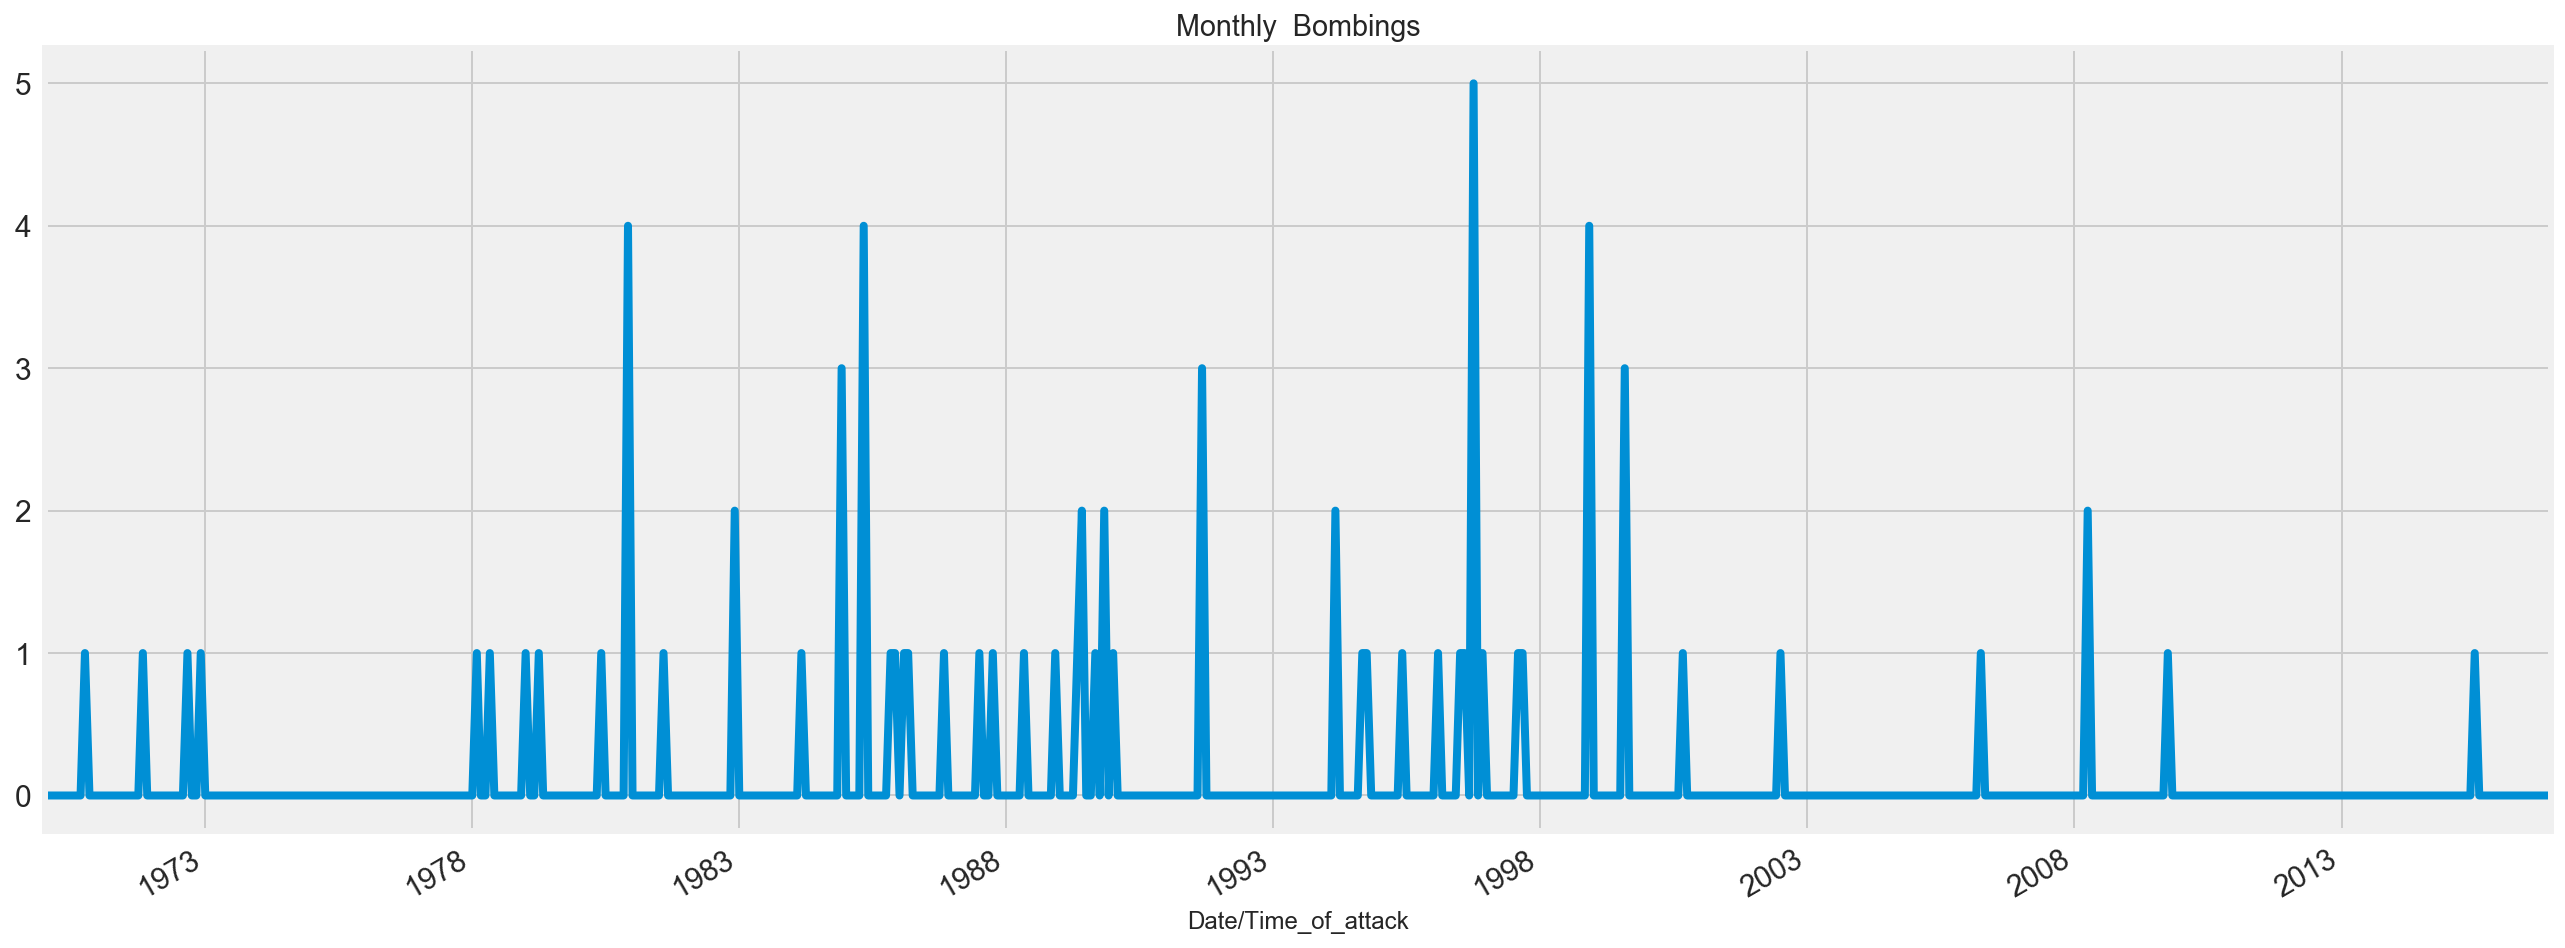

In [75]:
df_bombings_by_region['Australasia & Oceania'].plot(figsize=(20,8), fontsize=15, title='Monthly  Bombings')

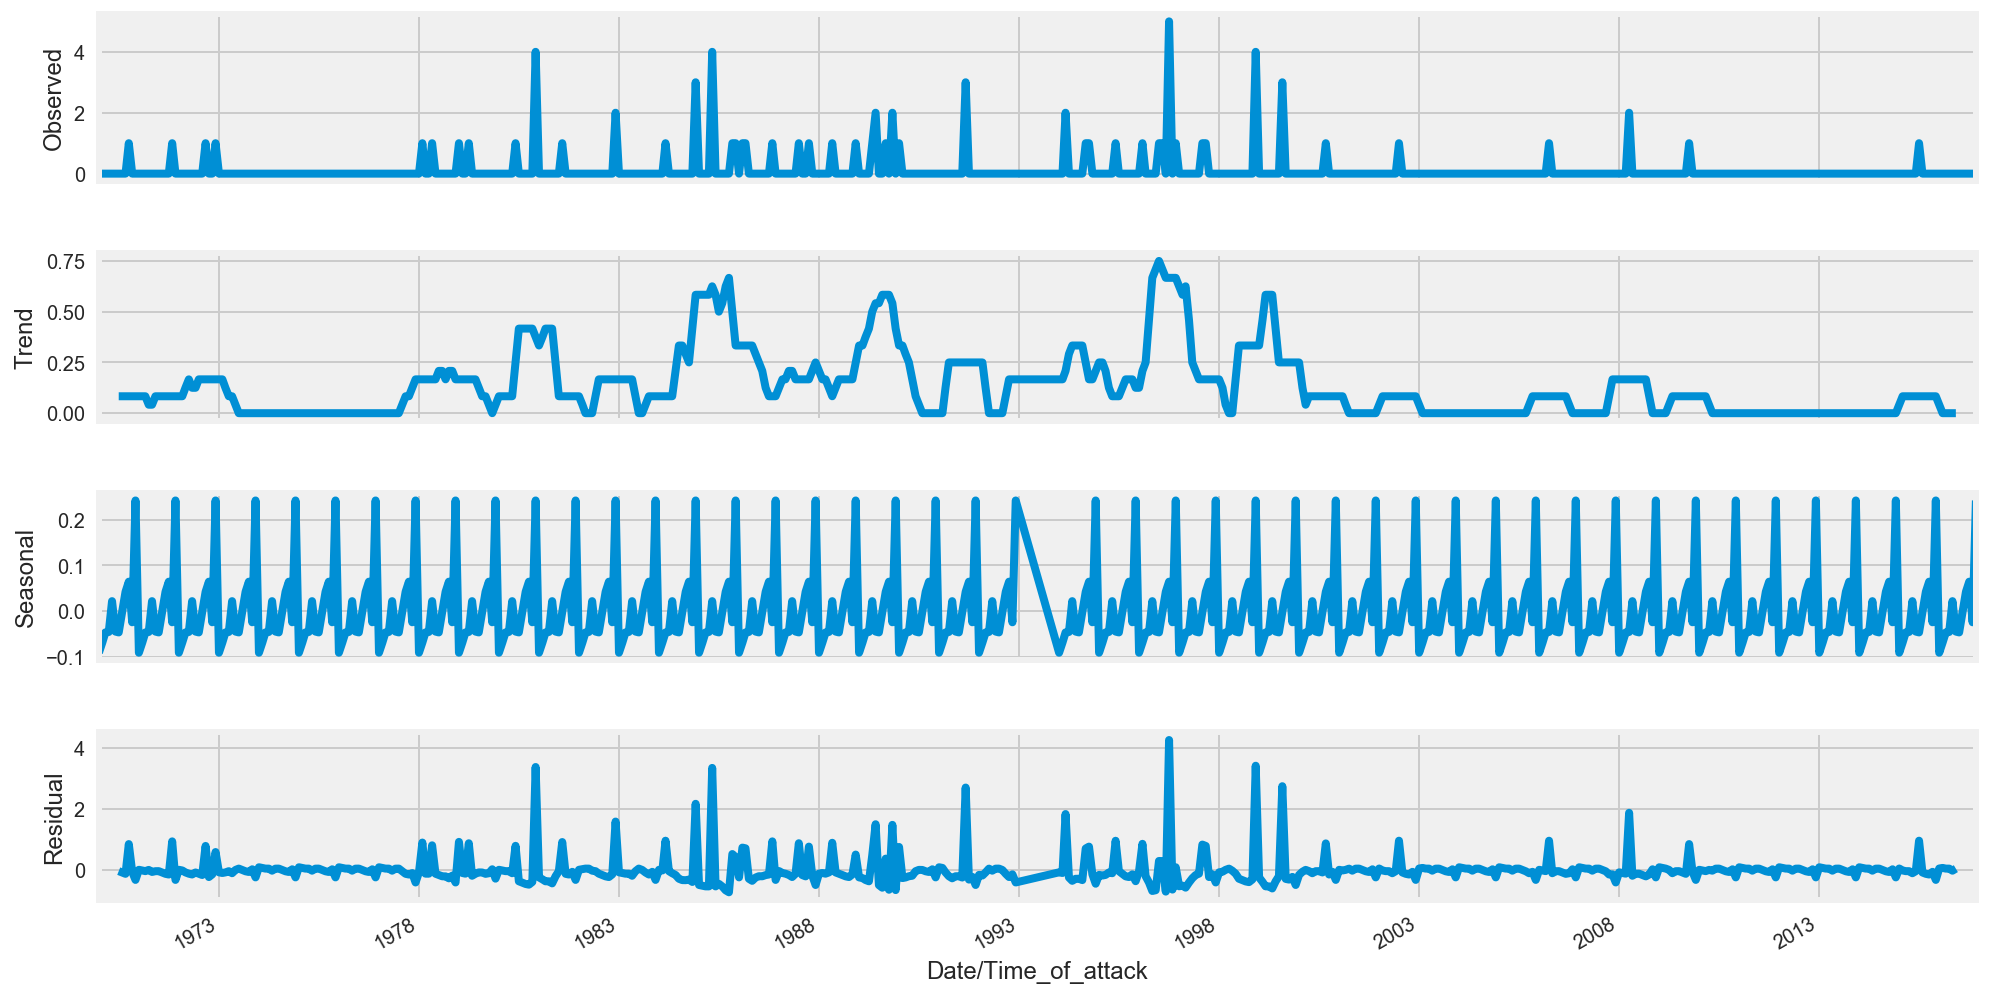

In [76]:
decomposition = seasonal_decompose(df_bombings_by_region['Australasia & Oceania'], freq=12)
fig = plt.figure()
fig = decomposition.plot()
fig.set_size_inches(15,8)



# decomposition = seasonal_decompose(df.riders, freq=12)  
# fig = plt.figure()  
# fig = decomposition.plot()  
# fig.set_size_inches(15, 8)

In [2]:
### Stationizing the data
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=12)
    rolstd = pd.rolling_std(timeseries, window=12)

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

/Users/elutins/anaconda/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
test_stationarity(df_bombings_by_region['Australasia & Oceania'])

NameError: name 'df_bombings_by_region' is not defined

In [80]:
from statsmodels.tsa.arima_model import ARMA

In [82]:
model = ARMA(df_bombings_by_region['Australasia & Oceania'], (1,0)).fit()
model.summary()

# model = ARMA(store1_sales_data, (1, 1)).fit()
# model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                ARMA Model Results                               
=================================================================================
Dep. Variable:     Australasia & Oceania   No. Observations:                  552
Model:                        ARMA(1, 0)   Log Likelihood                -418.633
Method:                          css-mle   S.D. of innovations              0.517
Date:                   Fri, 25 Aug 2017   AIC                            843.265
Time:                           16:36:16   BIC                            856.206
Sample:                       01-01-1970   HQIC                           848.321
                            - 12-01-2016                                         
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                           0.1323      0.022      6.124      0.000       0.090       0.175
ar.L1.Australasia & Oceania    -0.0181      0.043     -0.426      0.670      -0.101       0.065
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1          -55.2422           +0.0000j           55.2422            0.5000
-----------------------------------------------------------------------------
"""

In [89]:
model = ARMA(df_bombings_by_region['Australasia & Oceania'], (2,1)).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                ARMA Model Results                               
=================================================================================
Dep. Variable:     Australasia & Oceania   No. Observations:                  552
Model:                        ARMA(2, 1)   Log Likelihood                -414.936
Method:                          css-mle   S.D. of innovations              0.513
Date:                   Fri, 25 Aug 2017   AIC                            839.871
Time:                           16:38:18   BIC                            861.439
Sample:                       01-01-1970   HQIC                           848.298
                            - 12-01-2016                                         
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                           0.1177      0.052      2.247      0.025       0.015       0.220
ar.L1.Australasia & Oceania     0.9406      0.045     20.752      0.000       0.852       1.029
ar.L2.Australasia & Oceania     0.0481      0.043      1.119      0.264      -0.036       0.132
ma.L1.Australasia & Oceania    -0.9713      0.016    -59.383      0.000      -1.003      -0.939
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0110           +0.0000j            1.0110            0.0000
AR.2          -20.5784           +0.0000j           20.5784            0.5000
MA.1            1.0295           +0.0000j            1.0295            0.0000
-----------------------------------------------------------------------------
"""

In [96]:
# Formulating predictions for the model 
df_bombings_by_region['forecast'] = model.predict(start = 250, end = 300, dynamic=True) 

/Users/elutins/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  """Entry point for launching an IPython kernel.


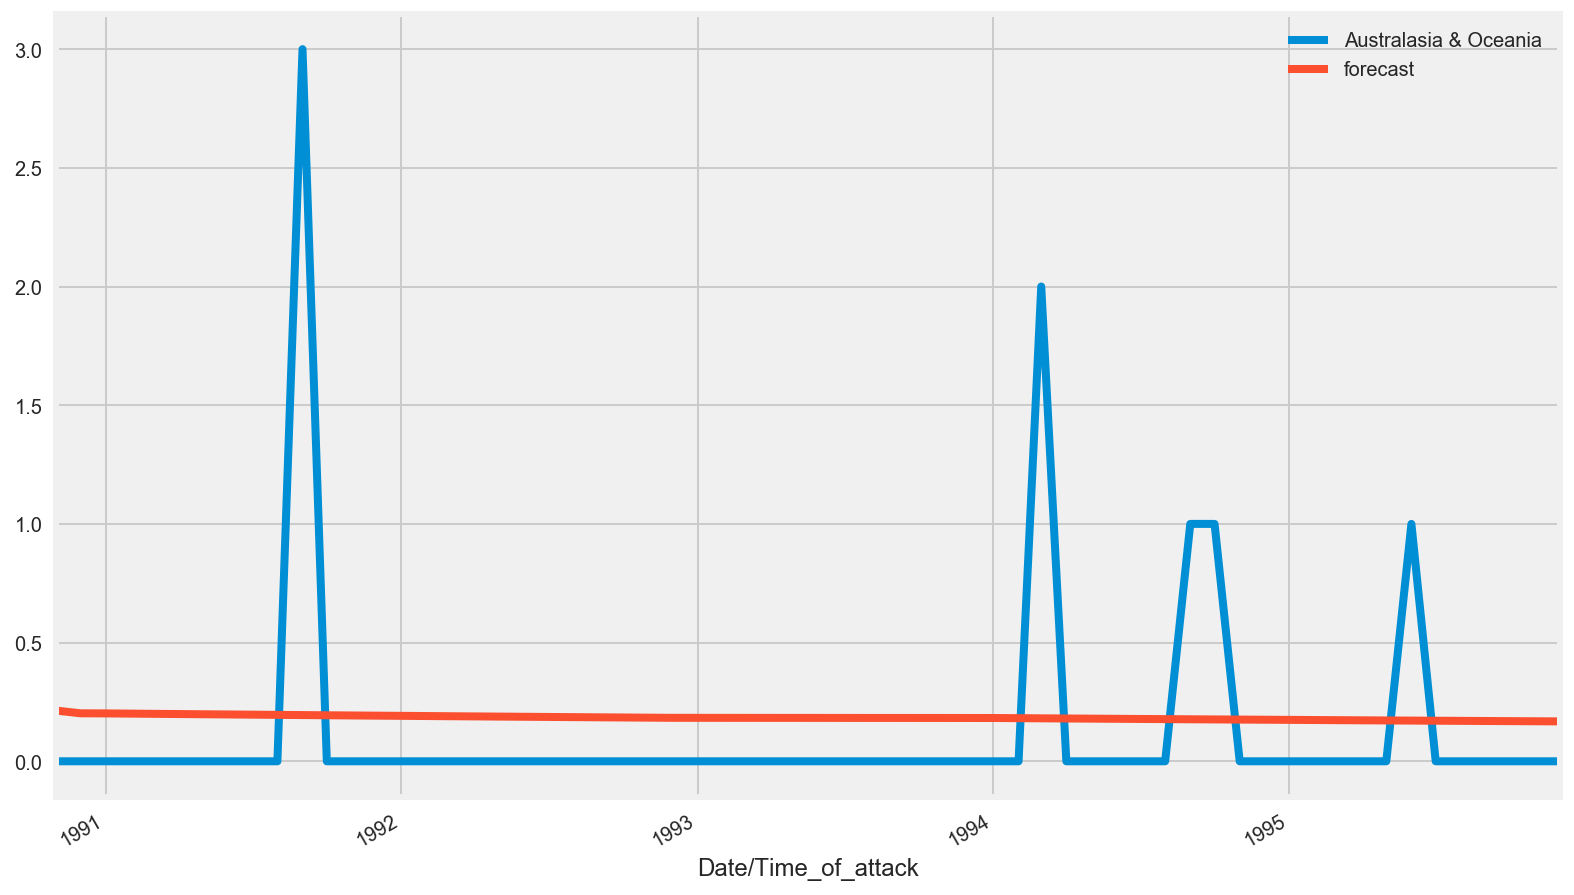

In [98]:
df_bombings_by_region[['Australasia & Oceania', 'forecast']].ix[250:300].plot(figsize=(12, 8)) 

/Users/elutins/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:6: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
  
/Users/elutins/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:7: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()
  import sys


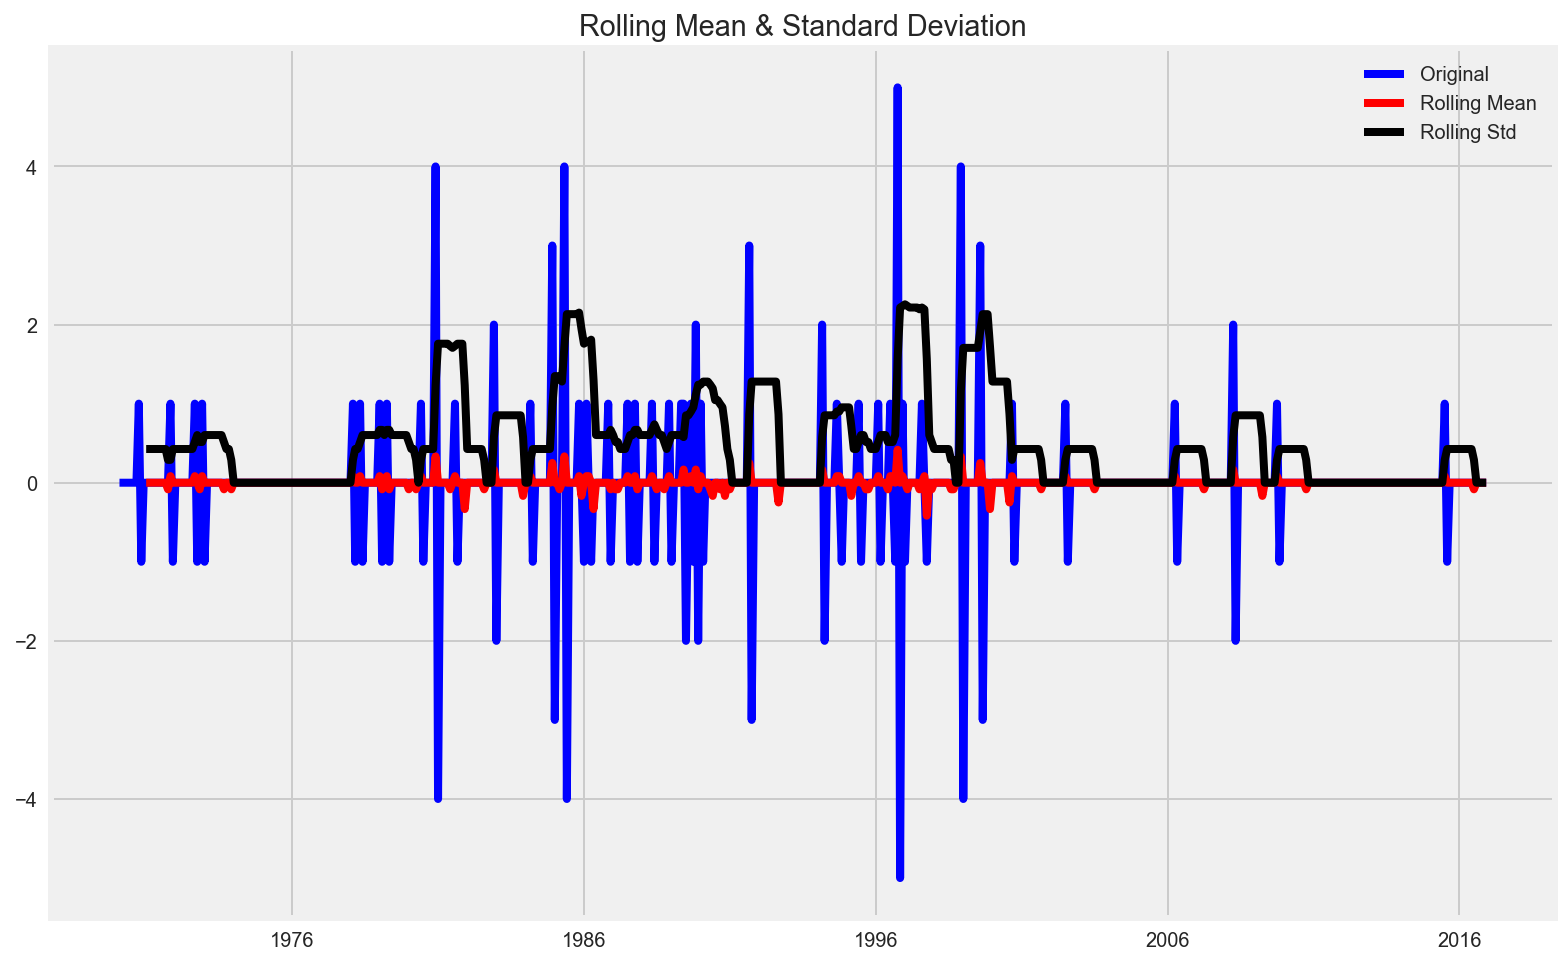

Results of Dickey-Fuller Test:
Test Statistic                -1.267815e+01
p-value                        1.203191e-23
#Lags Used                     9.000000e+00
Number of Observations Used    5.410000e+02
Critical Value (5%)           -2.866897e+00
Critical Value (1%)           -3.442495e+00
Critical Value (10%)          -2.569623e+00
dtype: float64


In [78]:
df_bombings_by_region['first_difference'] = df_bombings_by_region['Australasia & Oceania'] - df_bombings_by_region['Australasia & Oceania'].shift(1)  
test_stationarity(df_bombings_by_region.first_difference.dropna(inplace=False))

/Users/elutins/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:6: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
  
/Users/elutins/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:7: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()
  import sys


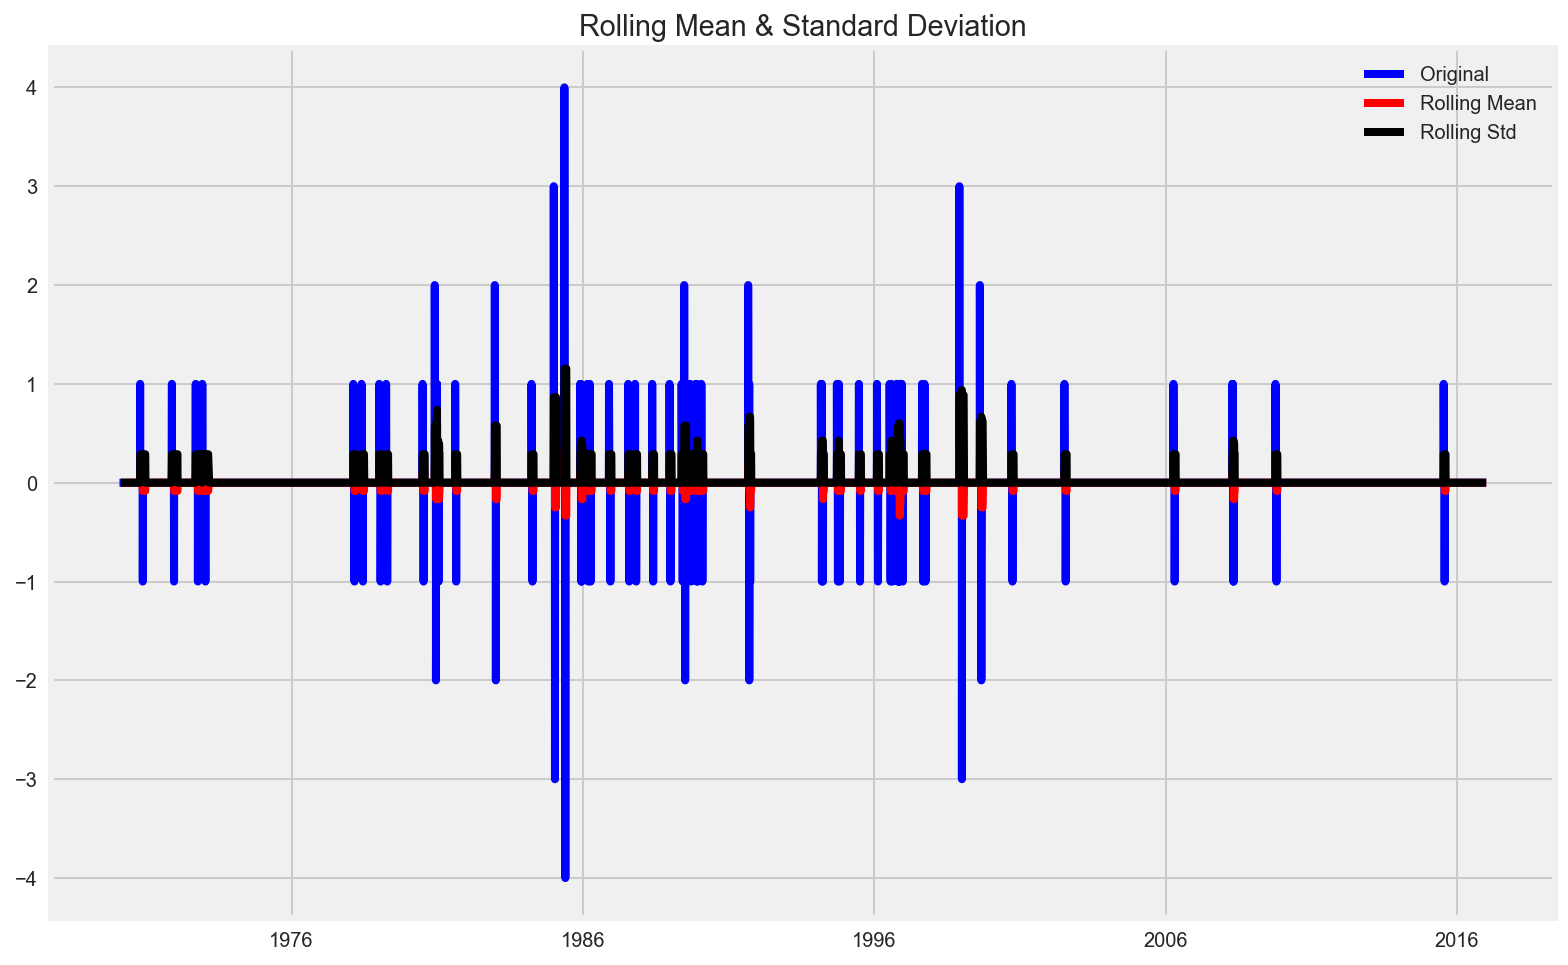

Results of Dickey-Fuller Test:
Test Statistic                   -32.613677
p-value                            0.000000
#Lags Used                        35.000000
Number of Observations Used    13602.000000
Critical Value (5%)               -2.861753
Critical Value (1%)               -3.430831
Critical Value (10%)              -2.566883
dtype: float64


In [59]:
df_bombings_by_region['seasonal_difference'] = df_bombings_by_region['Australasia & Oceania'] - 
                                                    df_bombings_by_region['Australasia & Oceania'].shift(12)  
test_stationarity(df_bombings_by_region.seasonal_difference.dropna(inplace=False))

/Users/elutins/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:6: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
  
/Users/elutins/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:7: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()
  import sys


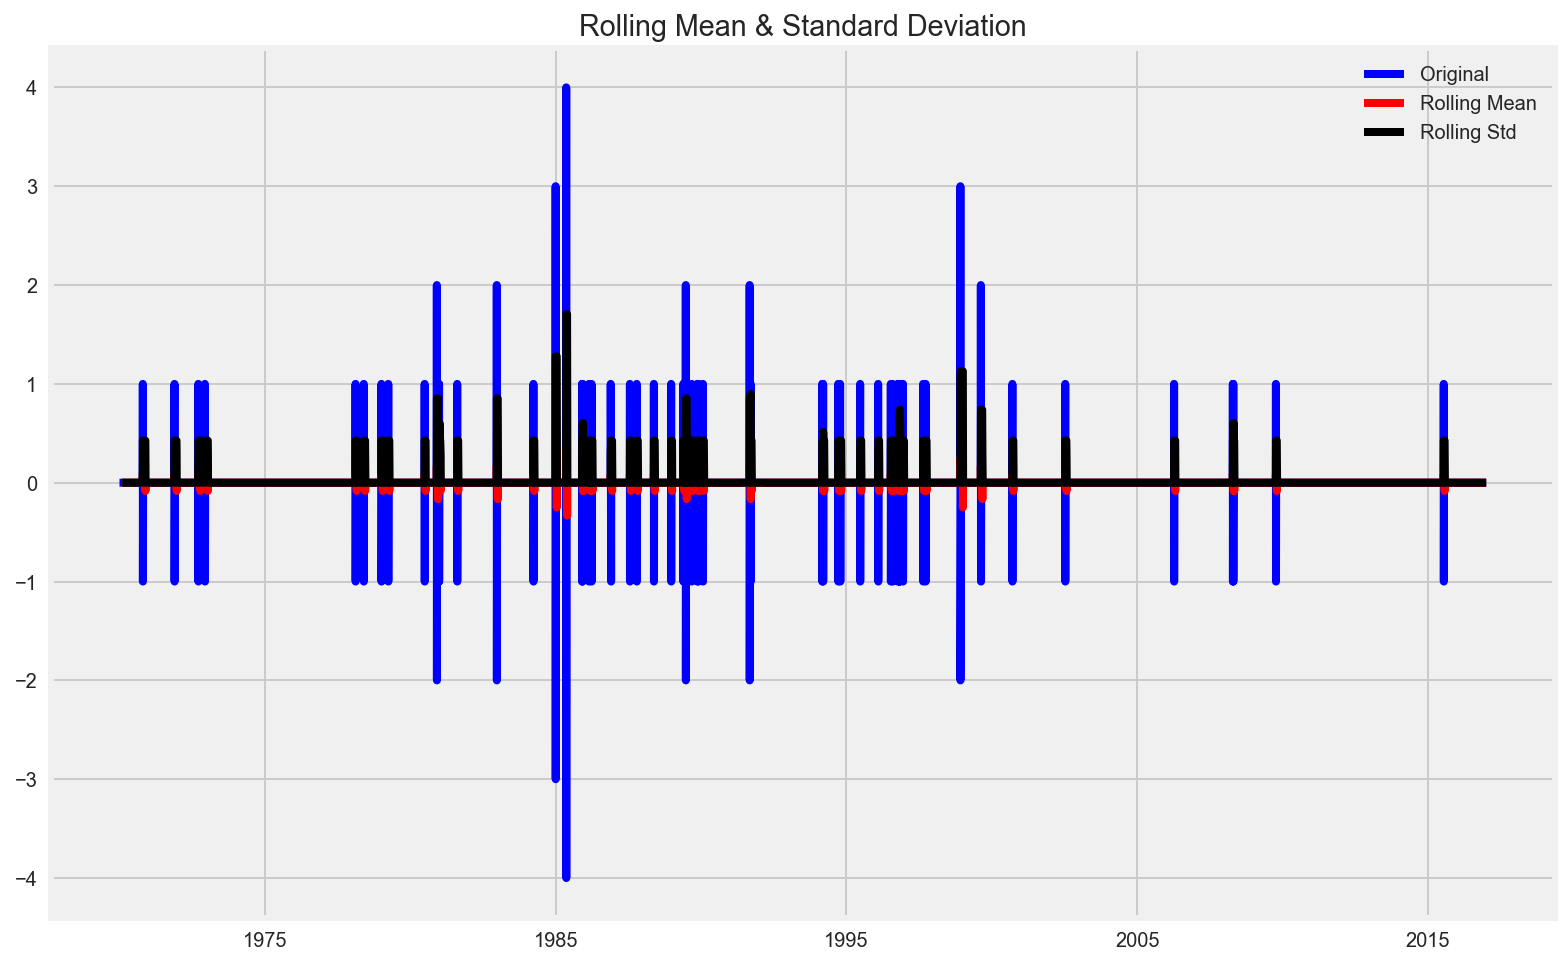

Results of Dickey-Fuller Test:
Test Statistic                   -29.831503
p-value                            0.000000
#Lags Used                        42.000000
Number of Observations Used    13606.000000
Critical Value (5%)               -2.861752
Critical Value (1%)               -3.430831
Critical Value (10%)              -2.566883
dtype: float64


In [61]:
df_bombings_by_region['seasonal_first_difference'] = df_bombings_by_region['first_difference'] -
                                                                df_bombings_by_region['first_difference'].shift(12)  
test_stationarity(df_bombings_by_region.first_difference.dropna(inplace=False))

### North America

In [1]:
test_stationarity(df_bombings_by_region['North America'])

NameError: name 'test_stationarity' is not defined

In [ ]:
NA_model_2 = ARMA(df_bombings_by_region['North America'], (0,1)).fit()
NA_model_2.summary()

In [ ]:
NA_model_3 = ARMA(df_bombings_by_region['North America'], (2,1)).fit()
NA_model_3.summary()

In [ ]:
# Of the above three models, the first proved to be the most accurate due to the lowest AIC score
# Formulating predictions for the model 
df_bombings_by_region['NA_forecast'] = NA_model.predict(start = 250, end = 300, dynamic=True) 

In [ ]:
# plotting predictions for North America
df_bombings_by_region[['North America', 'NA_forecast']].ix[250:300].plot(figsize=(12, 8), title='North American Predictions')

### Central America & Caribbean

In [ ]:
test_stationarity(df_bombings_by_region['Central America & Caribbean'])

In [ ]:
# Given that the above Test Statistic is greater than the 5% Critical Value, the data is not stationary. 
# testing the first difference for stationarity 
df_bombings_by_region['CA_Caribbean_first_difference'] = df_bombings_by_region['Central America & Caribbean'] - df_bombings_by_region['Central America & Caribbean'].shift(1)  
test_stationarity(df_bombings_by_region.CA_Caribbean_first_difference.dropna(inplace=False))

In [ ]:
# Now that Test-Statistic is below the 5% Critical Value Mark, data is stationary and we can proceed with modeling
# Plotting Auto-Correlation and Partion AC to check for optimal parameters
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df_bombings_by_region['Central America & Caribbean'], lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df_bombings_by_region['Central America & Caribbean'], lags=40, ax=ax2)

In [ ]:
CA_model = sm.tsa.statespace.SARIMAX(df_bombings_by_region['Central America & Caribbean'],
                                     trend='n',
                                     order=(1,1,0),
                                     seasonal_order=(0,1,1,12))

results = CA_model.fit()
results.summary()

In [ ]:
CA_model_2 = sm.tsa.statespace.SARIMAX(df_bombings_by_region['Central America & Caribbean'],
                                     trend='n',
                                     order=(0,1,1),
                                     seasonal_order=(0,1,1,12))

results2 = CA_model_2.fit()
results2.summary()

In [ ]:
# putting predictions into pandas series
predictions = pd.Series(results2.fittedvalues, copy=True)

# plotting predictions 
plt.plot(df_bombings_by_region['Central America & Caribbean'].ix[250:300])
plt.plot(predictions.ix[250:300], color='red')

In [ ]:
predictions.ix[250:300]

### South America

In [ ]:
test_stationarity(df_bombings_by_region['South America'])

In [ ]:
# Given that the above Test Statistic is greater than the 5% Critical Value, the data is not stationary. 
# testing the first difference for stationarity 
df_bombings_by_region['South_America_first_difference'] = df_bombings_by_region['South America'] - df_bombings_by_region['South America'].shift(1)  
test_stationarity(df_bombings_by_region.CA_Caribbean_first_difference.dropna(inplace=False))

In [ ]:
#Checking for seasonal stationarity
df_bombings_by_region['South_America_season_first_difference'] = df_bombings_by_region['South_America_first_difference'] - df_bombings_by_region['South_America_first_difference'].shift(12)  
test_stationarity(df_bombings_by_region.CA_Caribbean_first_difference.dropna(inplace=False))